# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Read Wind Energy Production Dataset

In [2]:
data = pd.read_csv('F:\APU\FYP\Dataset\Cleaned_data\wind_production_dataset.csv')

data.head()

,Country,Date,Value,Wind10int,Wind100int
0,Australia,2023-03-01,2415.8842,3.689722,5.550105
1,Australia,2023-02-01,2540.7584,3.966472,5.909515
2,Australia,2023-01-01,2614.8241,4.017246,5.866050
3,Australia,2022-12-01,2690.1965,4.128255,6.038626
4,Australia,2022-11-01,2510.9518,4.213749,6.209358


## Extract Data for each country

In [3]:
countries = data['Country'].unique()

wind_production_data = {}

# use loc() function to select data from a DataFrame based on specified row and column labels or conditions.
# Iterate over the countries
for country in countries:
    # Filter the data for the current country and 'wind' product
    country_energy_production = data.loc[
        (data['Country'] == country), ['Date', 'Value', 'Wind10int', 'Wind100int']
    ]
    
    # Store the filtered data in the dictionary
    wind_production_data[country] = country_energy_production.reset_index(drop=True)

wind_production_data['Germany']

,Date,Value,Wind10int,Wind100int
0,2023-03-01,14342.1549,4.019503,6.787114
1,2023-02-01,11957.5123,3.766190,6.406877
2,2023-01-01,17201.5540,4.348499,7.360450
3,2022-12-01,11865.3642,3.451154,6.033372
4,2022-11-01,12707.6513,3.459392,6.077384
...,...,...,...,...
154,2010-05-01,2692.0180,3.176225,5.078166
155,2010-04-01,3145.0560,3.229100,5.415262
156,2010-03-01,4901.1520,3.836795,6.514576
157,2010-02-01,3695.5880,3.585494,6.207611


# Resample to daily data

In [4]:
for country_data in wind_production_data:
    
    # set time as the index
    wind_production_data[country_data]['Date'] = pd.to_datetime(wind_production_data[country_data]['Date'])
    wind_production_data[country_data].set_index('Date', inplace=True)
    
    # divide the monthly statistical production value by the number of days 
    # of the month to get the avarage daily production value
    wind_production_data[country_data]['Value'] = (wind_production_data[country_data]['Value']/
                                                    wind_production_data[country_data].index.days_in_month)
    
    # resample the monthly index to daily and impute the missing value with linear interpolate method
    daily_data = wind_production_data[country_data].resample('D').interpolate('linear')
    wind_production_data[country_data] = daily_data
    
wind_production_data['Germany']

,Value,Wind10int,Wind100int
Date,,,
2010-01-01,93.757484,3.276909,5.449348
2010-01-02,94.990639,3.286863,5.473808
2010-01-03,96.223794,3.296817,5.498268
2010-01-04,97.456949,3.306772,5.522728
2010-01-05,98.690103,3.316726,5.547188
...,...,...,...
2023-02-25,457.564994,3.983315,6.732794
2023-02-26,458.836285,3.992362,6.746374
2023-02-27,460.107576,4.001409,6.759954


# Model Building

### Split train and test data

In [5]:
data = wind_production_data['Germany']

# Split the data into training and testing sets
split_date = '2021-01-01'
train, test = data[:split_date], data[split_date:]

print(train.head())
print(train.shape)
print()
print(test.head())
print(test.shape)

                Value  Wind10int  Wind100int
Date                                        
2010-01-01  93.757484   3.276909    5.449348
2010-01-02  94.990639   3.286863    5.473808
2010-01-03  96.223794   3.296817    5.498268
2010-01-04  97.456949   3.306772    5.522728
2010-01-05  98.690103   3.316726    5.547188
(4019, 3)

                 Value  Wind10int  Wind100int
Date                                         
2021-01-01  368.186652   3.630317    6.221842
2021-01-02  369.129683   3.623934    6.217116
2021-01-03  370.072714   3.617551    6.212390
2021-01-04  371.015745   3.611168    6.207664
2021-01-05  371.958777   3.604785    6.202938
(790, 3)


## Univariate Model - ARIMA - Daily

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

### The developer has use R with the auto.arima() function to identify the p, q, d value of the best fit ARIMA model for this dataset, the result shows that the order(p, q, d) = (0,0,0)(0,1,0)[365] 

#### Figure below show the result from R:
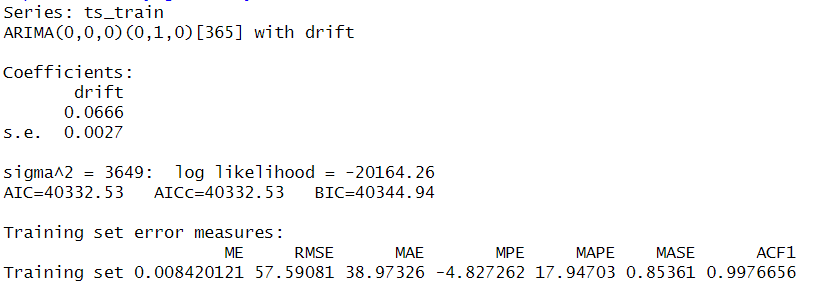

In [56]:
import rpy2.robjects as robjects
# Load the 'forecast' R package
robjects.r("library(forecast)")

# Load the ARIMA model
r_load = robjects.r['readRDS']
ger_wind_arima_model = r_load(r"F:\APU\FYP\SEM 2\Report Doc\R script\ger_wind_arima_model.rds")

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: This is forecast 8.21 
  Use suppressPackageStartupMessages() to eliminate package startup messages.

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: package 'forecast' was built under R version 4.1.3 



In [58]:
# Generate predictions
r_forecast = robjects.r['forecast']
predictions = r_forecast(ger_wind_arima_model, h=len(test))

# Evaluate the model performance
print("Mean Absolute Error: ", mean_absolute_error(predictions.rx('mean')[0], test['Value'].values))
mse = mean_squared_error(predictions.rx('mean')[0], test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", math.sqrt(mse))

Mean Absolute Error:  78.6016599611532
Mean Squared Error:  11826.823825849126
Root Mean Squared Error:  108.75120149151974


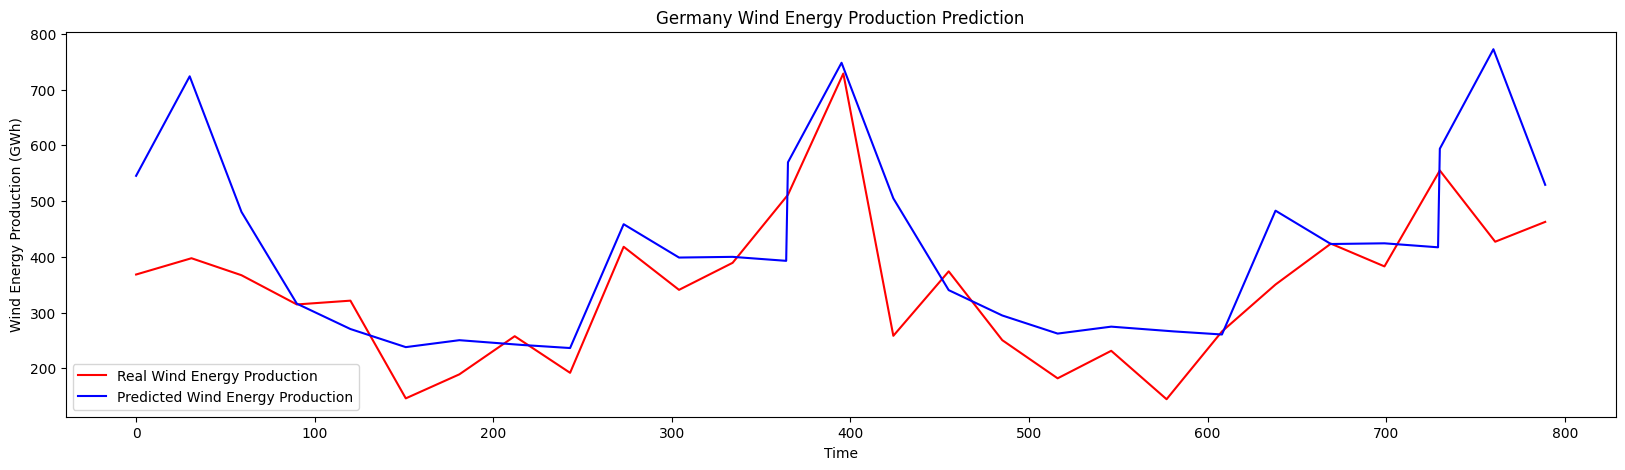

In [59]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Wind Energy Production')
plt.plot(predictions.rx('mean')[0], color = 'blue', label = 'Predicted Wind Energy Production')
plt.title('Germany Wind Energy Production Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy Production (GWh)')
plt.legend()
plt.show()

## XGBoost - Univariate

In [60]:
def create_features(df, label=None):

    #Creates time series features from datetime index
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype('int64')
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [61]:
X_train, y_train = create_features(train.copy(), label='Value')
X_test, y_test = create_features(test.copy(), label='Value')

print(X_train.head())
print(X_train.shape)
print()
print(y_train.head())
print(y_train.shape)
print()
print(X_test.head())
print(X_test.shape)
print()
print(y_test.head())
print(y_test.shape)

            dayofweek  quarter  month  year  dayofyear  dayofmonth  weekofyear
Date                                                                          
2010-01-01          4        1      1  2010          1           1          53
2010-01-02          5        1      1  2010          2           2          53
2010-01-03          6        1      1  2010          3           3          53
2010-01-04          0        1      1  2010          4           4           1
2010-01-05          1        1      1  2010          5           5           1
(4019, 7)

Date
2010-01-01    93.757484
2010-01-02    94.990639
2010-01-03    96.223794
2010-01-04    97.456949
2010-01-05    98.690103
Freq: D, Name: Value, dtype: float64
(4019,)

            dayofweek  quarter  month  year  dayofyear  dayofmonth  weekofyear
Date                                                                          
2021-01-01          4        1      1  2021          1           1          53
2021-01-02          5       

In [12]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [13]:
ger_daily_xgb = xgb.XGBRegressor(n_estimators=1000)
ger_daily_xgb.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=True)

C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:173.31030	validation_1-rmse:248.48509
[1]	validation_0-rmse:122.97702	validation_1-rmse:173.26329
[2]	validation_0-rmse:87.66486	validation_1-rmse:124.34274
[3]	validation_0-rmse:62.99095	validation_1-rmse:95.39907
[4]	validation_0-rmse:45.74045	validation_1-rmse:82.15353
[5]	validation_0-rmse:33.71627	validation_1-rmse:78.38921
[6]	validation_0-rmse:25.37581	validation_1-rmse:79.08827
[7]	validation_0-rmse:19.79707	validation_1-rmse:80.46824
[8]	validation_0-rmse:15.84518	validation_1-rmse:82.81928
[9]	validation_0-rmse:13.47332	validation_1-rmse:84.36928
[10]	validation_0-rmse:11.74877	validation_1-rmse:85.74126
[11]	validation_0-rmse:10.47690	validation_1-rmse:87.02391
[12]	validation_0-rmse:9.71854	validation_1-rmse:87.89244
[13]	validation_0-rmse:9.16421	validation_1-rmse:88.68488
[14]	validation_0-rmse:8.83862	validation_1-rmse:89.07429
[15]	validation_0-rmse:8.38024	validation_1-rmse:89.14519
[16]	validation_0-rmse:8.23624	validation_1-rmse:89.47045
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

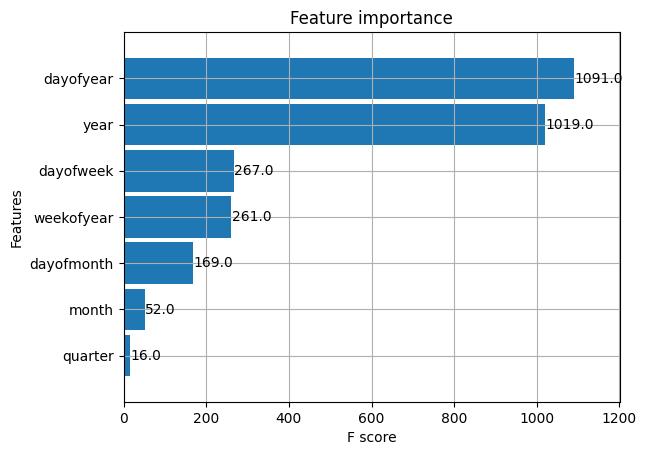

In [14]:
_ = plot_importance(ger_daily_xgb, height=0.9)

In [62]:
xgb_y_pred = ger_daily_xgb.predict(X_test)

In [63]:
print("Mean Absolute Error: ", mean_absolute_error(xgb_y_pred, test['Value'].values))
mse = mean_squared_error(xgb_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
import math
print("Root Mean Squared Error: ", math.sqrt(mse))

Mean Absolute Error:  60.84975386479091
Mean Squared Error:  6144.867552739818
Root Mean Squared Error:  78.38920558814088


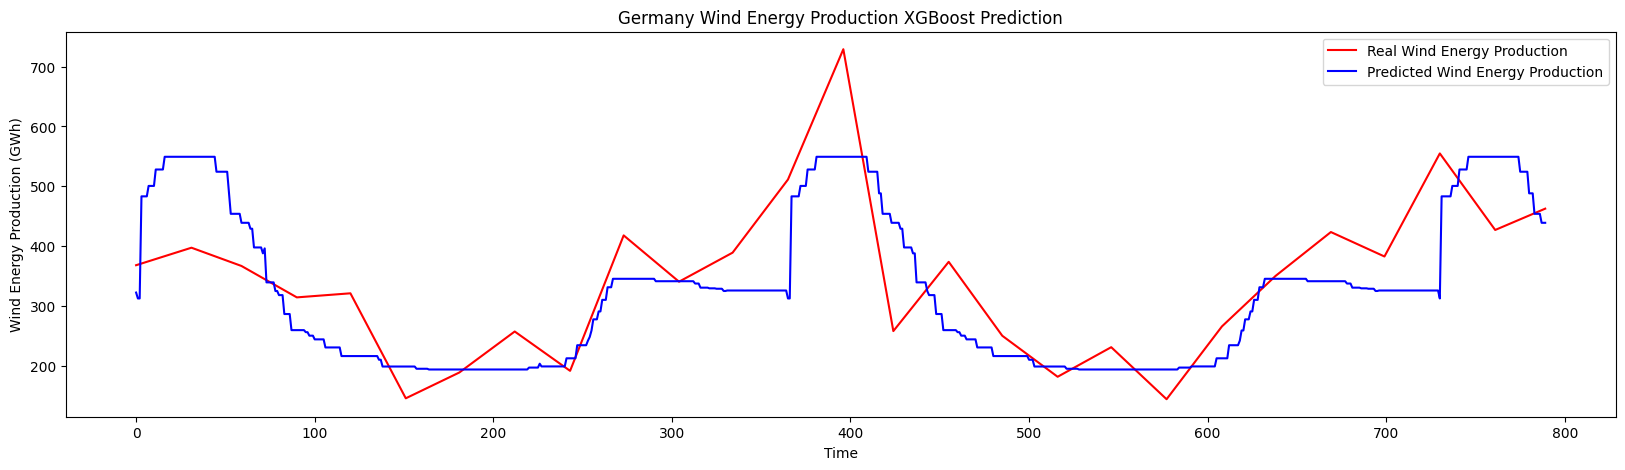

In [64]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Wind Energy Production')
plt.plot(xgb_y_pred, color = 'blue', label = 'Predicted Wind Energy Production')
plt.title('Germany Wind Energy Production XGBoost Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy Production (GWh)')
plt.legend()
plt.show()

## SVM - Univariate

In [18]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [65]:
# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['Value']].values)
test_scaled = scaler.transform(test[['Value']].values)

# Reshape the input data
time_steps = 365  # Define the number of previoGermany time steps to consider

# Creating a data structure with 365 timestamps and 1 output
x_train = []
y_train = []
for i in range(time_steps, len(train)):
    x_train.append(train_scaled[i-time_steps:i, 0])
    y_train.append(train_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape, y_train.shape)

(3654, 365) (3654,)


In [66]:
# Build and Train the SVM Model
ger_daily_svr = SVR(kernel='linear',gamma=0.5, C=10, epsilon = 0.01) # Specify hyperparameters
ger_daily_svr.fit(x_train, y_train)

SVR(C=10, epsilon=0.01, gamma=0.5, kernel='linear')

In [67]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
x_test = []
for i in range(time_steps, len(test)+time_steps):
    x_test.append(inputs[i-time_steps:i, 0])
x_test = np.array(x_test)

# Predict Wind Energy Production
svr_y_pred = ger_daily_svr.predict(x_test).reshape(-1,1)
svr_y_pred = scaler.inverse_transform(svr_y_pred)
print(svr_y_pred.shape)

(790, 1)


In [68]:
# Evaluate the model
print("Mean Absolute Error: ", mean_absolute_error(svr_y_pred, test['Value'].values))
mse = mean_squared_error(svr_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  4.014570508652888
Mean Squared Error:  27.30537520898984
Root Mean Squared Error:  5.225454545682111


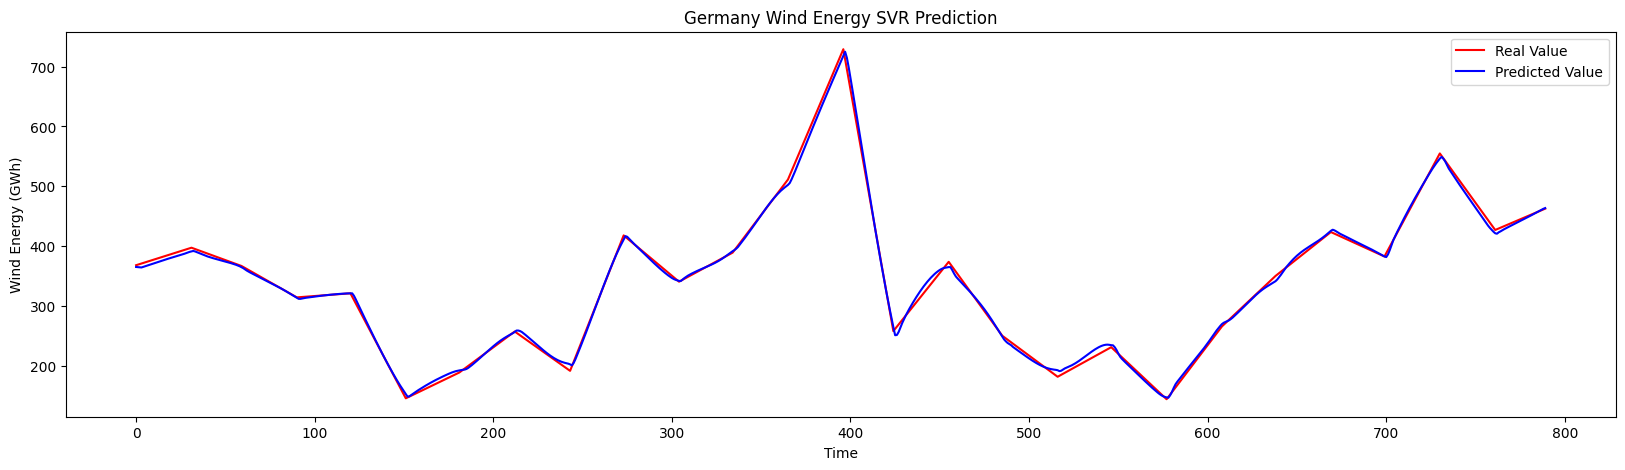

In [69]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color='red', label='Real Value')
plt.plot(svr_y_pred, color='blue', label='Predicted Value')
plt.title('Germany Wind Energy SVR Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

## Univariate GRU - Daily

In [70]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train[['Value']].values)

In [71]:
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Set the number of time steps (input sequence length)
time_steps = 365

# Create the training datasets
X_train, y_train = create_dataset(training_set_scaled, time_steps)

# Create the testing datasets
X_test, y_test = create_dataset(test['Value'].values, time_steps)

In [26]:
from keras.models import Sequential
from keras.layers import GRU, Dense

# Create the model
ger_daily_gru = Sequential()
ger_daily_gru.add(GRU(units=64, return_sequences=True, input_shape=(time_steps, 1)))
ger_daily_gru.add(GRU(units=64, input_shape=(time_steps, 1)))
ger_daily_gru.add(Dense(1, activation='linear'))

ger_daily_gru.compile(optimizer='adam', loss='mean_squared_error')

In [27]:
ger_daily_gru.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
115/115 [==============================] - 180s 818ms/step - loss: 0.0046
Epoch 2/100
115/115 [==============================] - 104s 905ms/step - loss: 1.4256e-04
Epoch 3/100
115/115 [==============================] - 91s 790ms/step - loss: 9.9883e-05
Epoch 4/100
115/115 [==============================] - 95s 824ms/step - loss: 7.2790e-05
Epoch 5/100
115/115 [==============================] - 102s 887ms/step - loss: 5.3070e-05
Epoch 6/100
115/115 [==============================] - 94s 820ms/step - loss: 2.4990e-05
Epoch 7/100
115/115 [==============================] - 90s 780ms/step - loss: 2.0163e-05
Epoch 8/100
115/115 [==============================] - 93s 808ms/step - loss: 1.6744e-05
Epoch 9/100
115/115 [==============================] - 94s 814ms/step - loss: 1.4861e-05
Epoch 10/100
115/115 [==============================] - 95s 824ms/step - loss: 1.2491e-05
Epoch 11/100
115/115 [==============================] - 93s 807ms/step - loss: 1.1820e-05
Epoch 12/100
115/115

115/115 [==============================] - 44s 381ms/step - loss: 4.9289e-06
Epoch 93/100
115/115 [==============================] - 45s 391ms/step - loss: 5.0309e-06
Epoch 94/100
115/115 [==============================] - 45s 387ms/step - loss: 3.6061e-06
Epoch 95/100
115/115 [==============================] - 39s 338ms/step - loss: 3.0021e-06
Epoch 96/100
115/115 [==============================] - 33s 286ms/step - loss: 2.5512e-06
Epoch 97/100
115/115 [==============================] - 36s 309ms/step - loss: 8.5452e-06
Epoch 98/100
115/115 [==============================] - 47s 405ms/step - loss: 4.9376e-06
Epoch 99/100
115/115 [==============================] - 46s 399ms/step - loss: 3.6610e-06
Epoch 100/100
115/115 [==============================] - 44s 383ms/step - loss: 7.1717e-06


In [72]:
# Getting the predicted value
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-time_steps:i, 0])
X_test = np.array(X_test)

gru_y_pred = ger_daily_gru.predict(X_test)
gru_y_pred = sc.inverse_transform(gru_y_pred)

25/25 [==============================] - 28s 244ms/step


In [73]:
print("Mean Absolute Error: ", mean_absolute_error(gru_y_pred, test['Value'].values))
mse = mean_squared_error(gru_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  3.0421871979450494
Mean Squared Error:  10.704116903266614
Root Mean Squared Error:  3.271714673266392


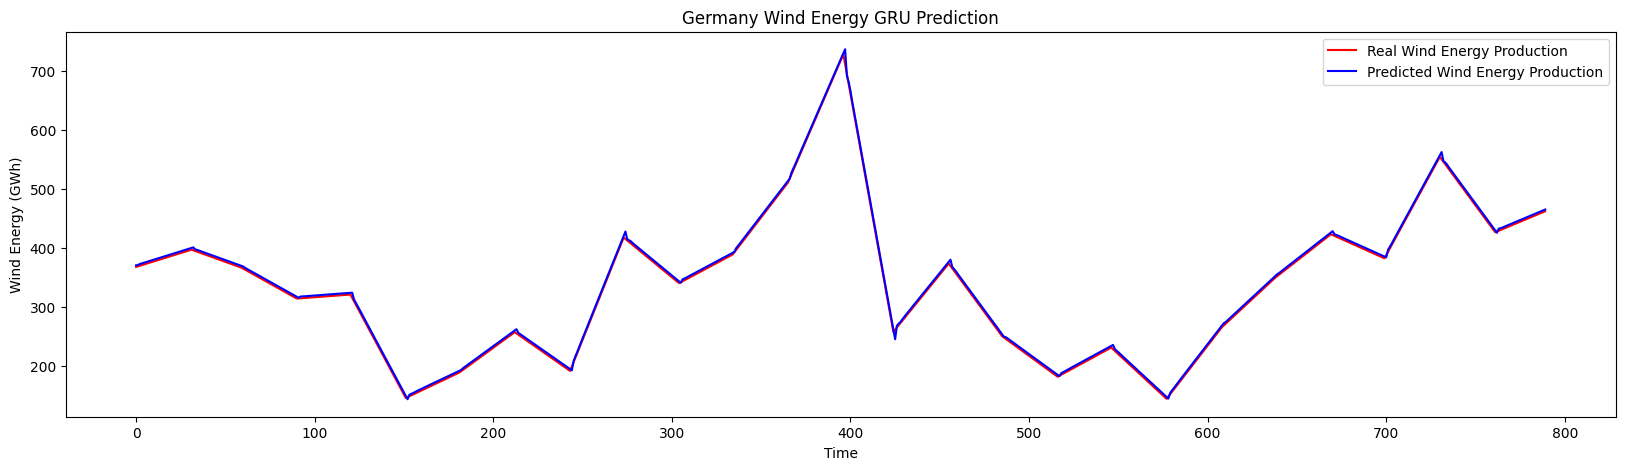

In [74]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Wind Energy Production')
plt.plot(gru_y_pred, color = 'blue', label = 'Predicted Wind Energy Production')
plt.title('Germany Wind Energy GRU Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

## Univariate LSTM - Daily

In [31]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train[['Value']].values)

print(training_set_scaled)
print(training_set_scaled.shape)

[[0.05728457]
 [0.05920318]
 [0.0611218 ]
 ...
 [0.48499916]
 [0.48462841]
 [0.48425765]]
(4019, 1)


In [32]:
# Creating a data structure with 365 timestamps and 1 output
X_train = []
y_train = []
for i in range(time_steps, len(train)):
    X_train.append(training_set_scaled[i-time_steps:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [33]:
print(X_train)
X_train.shape

[[0.05728457 0.05920318 0.0611218  ... 0.10578864 0.10741206 0.10903549]
 [0.05920318 0.0611218  0.06304041 ... 0.10741206 0.10903549 0.11065891]
 [0.0611218  0.06304041 0.06495903 ... 0.10903549 0.11065891 0.1131787 ]
 ...
 [0.71154119 0.71281554 0.72207955 ... 0.48611143 0.48574068 0.48536992]
 [0.71281554 0.72207955 0.73134357 ... 0.48574068 0.48536992 0.48499916]
 [0.72207955 0.73134357 0.74060758 ... 0.48536992 0.48499916 0.48462841]]


(3654, 365)

In [34]:
print(y_train)
y_train.shape

[0.11065891 0.1131787  0.11569848 ... 0.48499916 0.48462841 0.48425765]


(3654,)

In [35]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [36]:
# Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [37]:
# Initialising the RNN
ger_daily_uni_lstm = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
ger_daily_uni_lstm.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], 1)))
ger_daily_uni_lstm.add(Dropout(0.2))

ger_daily_uni_lstm.add(LSTM(units = 64, return_sequences = True))
ger_daily_uni_lstm.add(Dropout(0.2))

ger_daily_uni_lstm.add(LSTM(units = 64))
ger_daily_uni_lstm.add(Dropout(0.2))

# Adding the output layer
ger_daily_uni_lstm.add(Dense(units = 1))

In [38]:
# Compiling the RNN
ger_daily_uni_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
ger_daily_uni_lstm.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
115/115 [==============================] - 116s 577ms/step - loss: 0.0055
Epoch 2/100
115/115 [==============================] - 69s 599ms/step - loss: 0.0015
Epoch 3/100
115/115 [==============================] - 73s 639ms/step - loss: 0.0012
Epoch 4/100
115/115 [==============================] - 71s 620ms/step - loss: 0.0010
Epoch 5/100
115/115 [==============================] - 73s 634ms/step - loss: 9.0124e-04
Epoch 6/100
115/115 [==============================] - 76s 656ms/step - loss: 7.7271e-04
Epoch 7/100
115/115 [==============================] - 72s 627ms/step - loss: 7.1885e-04
Epoch 8/100
115/115 [==============================] - 71s 621ms/step - loss: 7.5423e-04
Epoch 9/100
115/115 [==============================] - 75s 656ms/step - loss: 6.6996e-04
Epoch 10/100
115/115 [==============================] - 74s 644ms/step - loss: 5.9499e-04
Epoch 11/100
115/115 [==============================] - 72s 630ms/step - loss: 6.0286e-04
Epoch 12/100
115/115 [============

In [39]:
test[['Value']].shape

(790, 1)

In [75]:
# Getting the predicted stock price of 2017
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-time_steps:i, 0])
    y_test.append(inputs[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
uni_lstm_y_pred = ger_daily_uni_lstm.predict(X_test)
uni_lstm_y_pred = sc.inverse_transform(uni_lstm_y_pred)

25/25 [==============================] - 22s 174ms/step


In [76]:
print("Mean Absolute Error: ", mean_absolute_error(uni_lstm_y_pred, test['Value'].values))
mse = mean_squared_error(uni_lstm_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  4.045329647684411
Mean Squared Error:  31.929940729876773
Root Mean Squared Error:  5.650658433304633


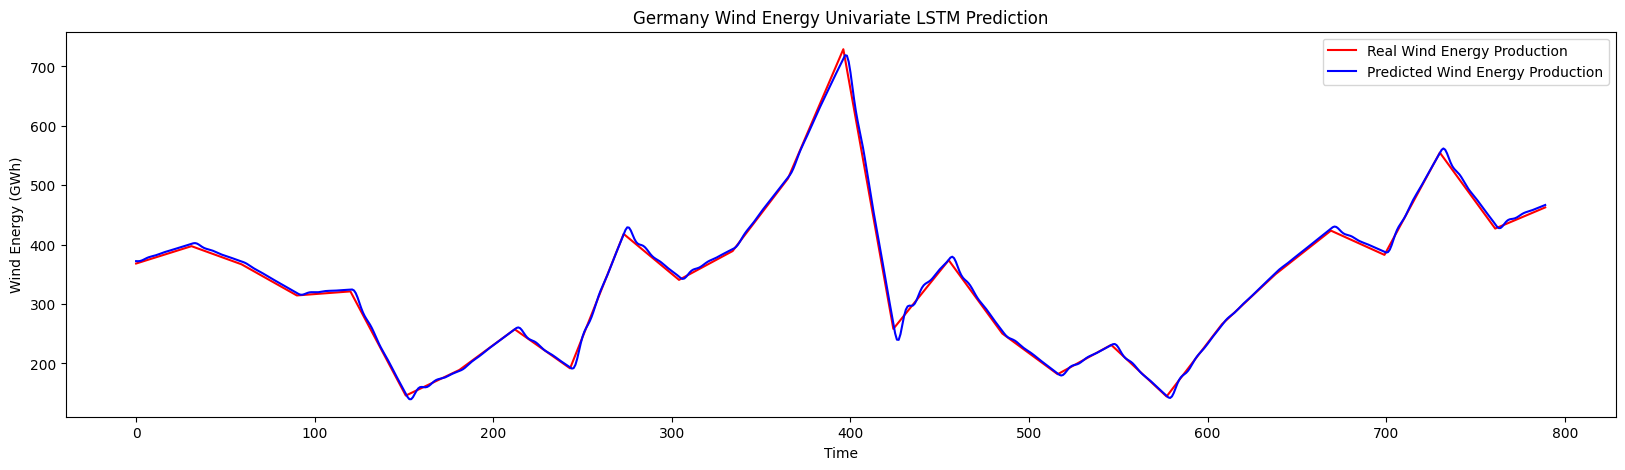

In [77]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Wind Energy Production')
plt.plot(uni_lstm_y_pred, color = 'blue', label = 'Predicted Wind Energy Production')
plt.title('Germany Wind Energy Univariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

## Multivariate LSTM

In [79]:
data = wind_production_data['Germany']

data.shape

(4808, 3)

In [80]:
X = data[['Wind10int', 'Wind100int', 'Value']]
y = data[['Value']]

X.head()

,Wind10int,Wind100int,Value
Date,,,
2010-01-01,3.276909,5.449348,93.757484
2010-01-02,3.286863,5.473808,94.990639
2010-01-03,3.296817,5.498268,96.223794
2010-01-04,3.306772,5.522728,97.456949
2010-01-05,3.316726,5.547188,98.690103


In [81]:
# Split the data into training and testing sets
split_date = '2021-01-01'
X_train, X_test = X[:split_date], X[split_date:]
y_train, y_test = y[:split_date], y[split_date:]

In [82]:
# Scale the features and target variables using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
X_train, X_test = X_scaler.fit_transform(X_train), X_scaler.transform(X_test)
y_train, y_test = y_scaler.fit_transform(y_train), y_scaler.transform(y_test)

In [83]:
print(X_train.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(y_test.shape)

(4019, 3)
(790, 3)

(4019, 1)
(790, 1)


In [84]:
# Reshape the input data to fit the LSTM model (samples, time steps, features)
time_steps = 365  # Define the number of previoGermany time steps to consider
n_features = X_train.shape[1]  # Number of features

# Creating a data structure with 365 timestamps and 1 output
X_train1 = []
y_train1 = []
for i in range(time_steps, len(X_train)):
    X_train1.append(X_train[i-time_steps:i])
    y_train1.append(y_train[i][0])
X_train1, y_train1 = np.array(X_train1), np.array(y_train1)

print(X_train1.shape)

(3654, 365, 3)


In [85]:
X_train1 = np.reshape(X_train1, (X_train1.shape[0], X_train1.shape[1], X_train1.shape[2]))

In [50]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

ger_daily_multi_lstm = Sequential()
ger_daily_multi_lstm.add(LSTM(units = 64, return_sequences = True, input_shape=(time_steps, n_features)))
ger_daily_multi_lstm.add(Dropout(0.2))
ger_daily_multi_lstm.add(LSTM(units = 64, activation = 'relu', return_sequences = True))
ger_daily_multi_lstm.add(Dropout(0.2))
ger_daily_multi_lstm.add(LSTM(units = 64))
ger_daily_multi_lstm.add(Dropout(0.2))
ger_daily_multi_lstm.add(Dense(1))

In [51]:
ger_daily_multi_lstm.compile(optimizer='adam', loss='mean_squared_error')

ger_daily_multi_lstm.fit(X_train1, y_train1, epochs=100, batch_size=32)

Epoch 1/100
115/115 [==============================] - 217s 879ms/step - loss: 0.0075
Epoch 2/100
115/115 [==============================] - 98s 852ms/step - loss: 0.0013
Epoch 3/100
115/115 [==============================] - 92s 799ms/step - loss: 0.0013
Epoch 4/100
115/115 [==============================] - 98s 852ms/step - loss: 9.7957e-04
Epoch 5/100
115/115 [==============================] - 99s 859ms/step - loss: 0.0012
Epoch 6/100
115/115 [==============================] - 98s 847ms/step - loss: 8.4277e-04
Epoch 7/100
115/115 [==============================] - 98s 849ms/step - loss: 6.8338e-04
Epoch 8/100
115/115 [==============================] - 96s 838ms/step - loss: 7.3165e-04
Epoch 9/100
115/115 [==============================] - 101s 883ms/step - loss: 7.7419e-04
Epoch 10/100
115/115 [==============================] - 101s 870ms/step - loss: 6.6017e-04
Epoch 11/100
115/115 [==============================] - 98s 849ms/step - loss: 6.7029e-04
Epoch 12/100
115/115 [==========

Epoch 92/100
115/115 [==============================] - 46s 400ms/step - loss: 2.5133e-04
Epoch 93/100
115/115 [==============================] - 45s 395ms/step - loss: 2.2136e-04
Epoch 94/100
115/115 [==============================] - 46s 404ms/step - loss: 2.3375e-04
Epoch 95/100
115/115 [==============================] - 43s 378ms/step - loss: 2.6486e-04
Epoch 96/100
115/115 [==============================] - 34s 299ms/step - loss: 2.3516e-04
Epoch 97/100
115/115 [==============================] - 34s 294ms/step - loss: 2.2942e-04
Epoch 98/100
115/115 [==============================] - 35s 306ms/step - loss: 2.4273e-04
Epoch 99/100
115/115 [==============================] - 35s 308ms/step - loss: 2.4056e-04
Epoch 100/100
115/115 [==============================] - 42s 366ms/step - loss: 2.3033e-04


In [86]:
X_total_data = X
inputs = X_total_data[len(X_total_data) - len(X_test) - 365:]
inputs = X_scaler.transform(inputs)
print(inputs.shape)
len(X_test)
X_test1 = []
for i in range(time_steps, len(X_test)+time_steps):
    X_test1.append(inputs[i-time_steps:i])
X_test1 = np.array(X_test1)
X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], X_test1.shape[2]))
multi_lstm_y_pred = ger_daily_multi_lstm.predict(X_test1)
multi_lstm_y_pred = y_scaler.inverse_transform(multi_lstm_y_pred)
real_value = y_scaler.inverse_transform(y_test)
hist_value = y_scaler.inverse_transform(y_train)
multi_lstm_y_pred

(1155, 3)
25/25 [==============================] - 20s 152ms/step


array([[373.1104 ],
       [372.8593 ],
       [372.47116],
       [372.08734],
       [372.04565],
       [372.63562],
       [373.8671 ],
       [375.4921 ],
       [377.1687 ],
       [378.64493],
       [379.8497 ],
       [380.86584],
       [381.8327 ],
       [382.85266],
       [383.949  ],
       [385.08118],
       [386.19083],
       [387.24203],
       [388.23538],
       [389.19537],
       [390.14868],
       [391.10696],
       [392.06485],
       [393.00842],
       [393.9268 ],
       [394.8189 ],
       [395.6938 ],
       [396.56427],
       [397.44177],
       [398.33212],
       [399.2366 ],
       [400.1542 ],
       [401.08438],
       [401.7744 ],
       [401.845  ],
       [401.10202],
       [399.6249 ],
       [397.7311 ],
       [395.79916],
       [394.09363],
       [392.68597],
       [391.4875 ],
       [390.3502 ],
       [389.16302],
       [387.89584],
       [386.58502],
       [385.28818],
       [384.04333],
       [382.85342],
       [381.69608],


In [87]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Mean Absolute Error: ", mean_absolute_error(multi_lstm_y_pred, real_value))
mse = mean_squared_error(multi_lstm_y_pred, real_value)
print("Mean Squared Error: ", mse)
import math
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  4.474943074793203
Mean Squared Error:  47.77340615082633
Root Mean Squared Error:  6.911830882684148


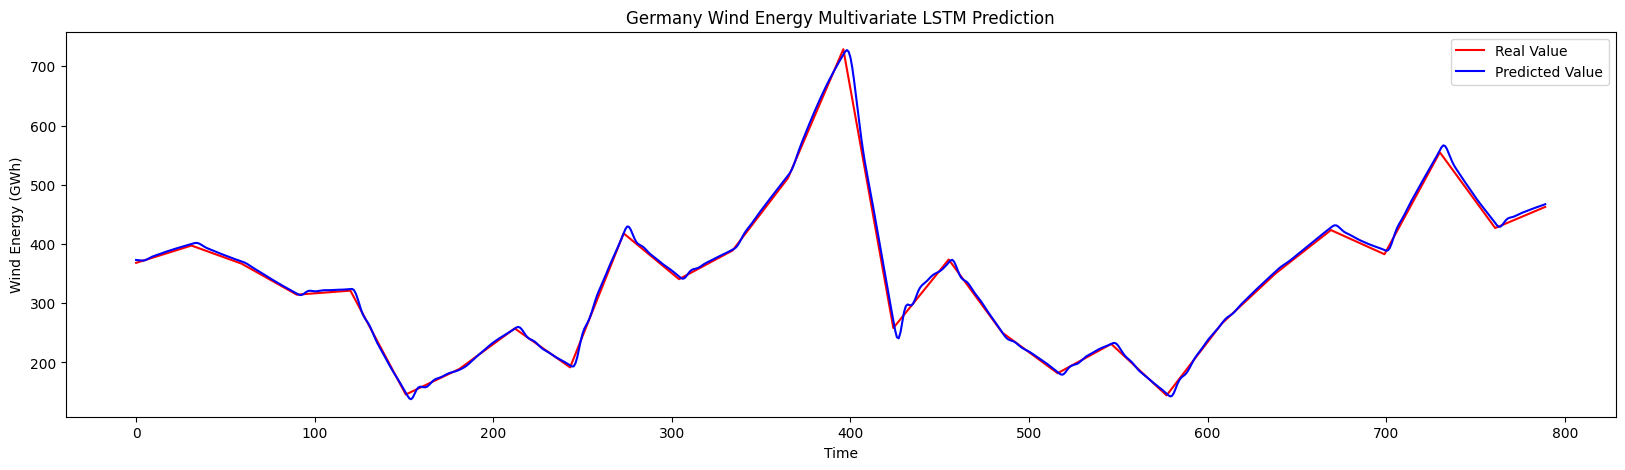

In [88]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='red', label='Real Value')
plt.plot(multi_lstm_y_pred, color='blue', label='Predicted Value')
plt.title('Germany Wind Energy Multivariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

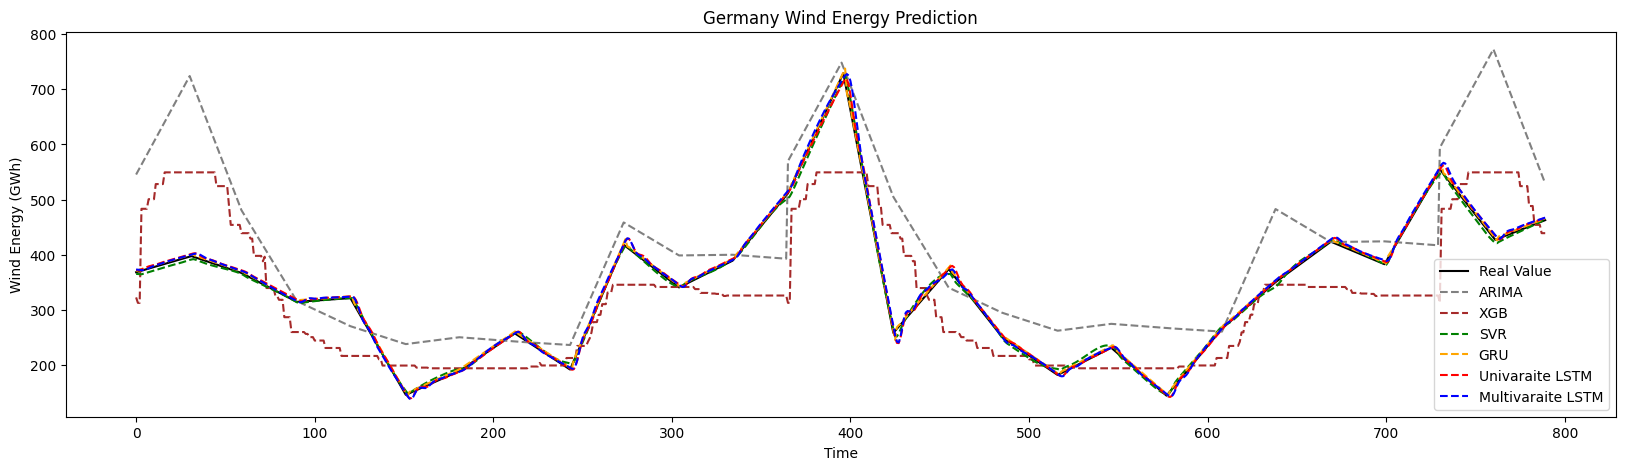

In [90]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='black', label='Real Value')
plt.plot(predictions.rx('mean')[0], color='grey', linestyle='--', label='ARIMA')
plt.plot(xgb_y_pred, color='brown', linestyle='--', label='XGB')
plt.plot(svr_y_pred, color='green', linestyle='--', label='SVR')
plt.plot(gru_y_pred, color='orange', linestyle='--', label='GRU')
plt.plot(uni_lstm_y_pred, color='red', linestyle='--', label='Univaraite LSTM')
plt.plot(multi_lstm_y_pred, color='blue', linestyle='--', label='Multivaraite LSTM')
plt.title('Germany Wind Energy Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

# Save Best Model

In [55]:
ger_daily_gru.save("ger_wind_best_gru.h5")

C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
